# Regulatory potential modeling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AllenWLynch/MIRA/blob/main/docs/source/notebooks/tutorial_cisregulatory_modeling.ipynb)

MIRA approaches the problem of comparing gene expression and accessibility at the cell and gene levels. The previous tutorials covered cell-level analyses - topic modeling, pseudotime trajectory inference, etc. This tutorial will cover gene-level Regulatory Potential modeling (RP modeling). 

A regulatory potential model relates a gene's expression to nearby *cis*-regulatory elements (CREs). While linking changes in accessibility to changes in gene expression is confounded by cell-wide changes in state, proximity of a CRE to the TSS of a gene gives a mechanistic justification to assume some regulatory effect. Thus, MIRA learns upstream and downstream decay distances that describe the range at which changes in local accessible chromatin appear to influence expression. Each RP model is a statistical model describing a gene's relationship with its local chromatin neighborhood. 

We can use RP models to:

* Predict the expression state of a gene given its local chromatin state
* Find transcription factors that bind potential regulatory sites around each gene
* Understand the regulatory ranges of influence around genes
* Identify genes where local chromatin and expression are out-of-sync.

Let's start by importing some packages:

In [ ]:
!pip install mira-multiome==1.0.0.rc4 scanpy==1.8.2 numpy==1.20.1

In [1]:
import mira
import scanpy as sc
import anndata
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
mira.utils.pretty_sderr()

and downloading the SHARE-seq skin dataset (if not downloaded already):

In [2]:
mira.datasets.ShareseqTopicModels()
mira.datasets.ShareseqAnnotatedData()

rna_data = anndata.read_h5ad('mira-datasets/shareseq_annotated_data/rna_data.joint_representation.rp_modeled.h5ad')
atac_data = anndata.read_h5ad('mira-datasets/shareseq_annotated_data/atac_data.joint_representation.motif_calls.tss_annotated.h5ad')

rna_model = mira.topics.ExpressionTopicModel.load('mira-datasets/shareseq_topic_models/rna_model.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('mira-datasets/shareseq_topic_models/atac_model.pth')

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* atac_model.pth
	* rna_model.pth
INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* rna_data.joint_representation.rp_modeled.h5ad
	* atac_data.joint_representation.motif_calls.tss_annotated.h5ad
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [3]:
rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)

INFO:mira.adata_interface.utils:24653 out of 24653 cells shared between datasets (100%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features


In [4]:
atac_model.encoder.calc_readdepth = False

## TSS annotations

To start, we must annotate the genes in our multiome dataset with TSS locations. Each gene symbol (or however you wish to identify your genes), must be associated with a unique TSS. If a gene symbol has multiple TSS annotations, only the first will be used.

The required information for each gene is the:

1. chromosome
2. transcription start
3. transcription end
4. strand
5. symbol/identifier

Non-redundant human (hg38 GENCODE VM39) and mouse (mm10 GENCODE VM23) TSS annotations are available to download through MIRA, but you can assemble your own TSS dataframe. You can see how these annotations were assembled and get instructions on assembling your own annotation by following [this tutorial](tutorial_assemble_gene_annotations.html).

To run [mira.tl.get_distance_to_TSS](Tools/mira.tl.get_distance_to_TSS.html), first download the chromosome sizes and TSS annotations provided by MIRA. Equivalent methods are available for hg38:

```
mira.datasets.hg38_chrom_sizes()
mira.datasets.hg38_tss_data()
```

In [5]:
mira.datasets.mm10_chrom_sizes()
mira.datasets.mm10_tss_data()

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/mm10.chrom.sizes
INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/mm10_tss_data.bed12


In [6]:
!head -n3 mira-datasets/mm10.chrom.sizes

chr1	195471971
chr2	182113224
chrX	171031299


In [7]:
!head -n3 mira-datasets/mm10_tss_data.bed12

#chrom	#txStart	#txEnd	#geneSymbol	#score	#strand	#thickStart	#thickEnd	#itemRGB	#exonCount	#blockSizes	#blockStarts
chr1	3073252	3074322	4933401J01RIK	0	+	0	0	0	1	1070	0
chr1	3102015	3102125	GM26206	0	+	0	0	0	1	110	0


If you have your own annotation with different column names, you can pass those column names as keyword arguments to `mira.tl.get_distance_to_TSS`. *The column names must exclude the preceeding "#", if applicable.*

In [8]:
mira.tl.get_distance_to_TSS(atac_data, 
                            tss_data='mira-datasets/mm10_tss_data.bed12', 
                            genome_file='mira-datasets/mm10.chrom.sizes')

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


## RP model training

With TSS annotations in place, we can train RP models. Most RP-model related functions take the `expr_adata` and `atac_adata` keyword arguments, so it's easiest to put them into a dictionary for repeated use:

In [9]:
rp_args = dict(expr_adata = rna_data, atac_adata= atac_data) 

Next, we instantiate an RP Model. MIRA refers to the RP model variant that uses local chromatin to predict gene expression as a *LITE* model - or **L**ocal chromatin accessibility-**I**nfluenced **T**ranscriptional **E**xpression model. 

The [mira.rp.LITE_Model](rpmodeling/mira.rp.LITE_Model.html#mira.rp.LITE_Model) object takes the expression and accessibility topic models. You must also define a list of genes to model. To keep this short, I will demonstrate training with four genes, but in a full analysis, we recommend training models for *all highly-variable genes, plus all genes that scored in the top 5% most-activated for any topic*, which gives a good survey of interesting gene expression variation in your data. This following snippet gives you that genelist:

```
rp_genes = list(rna_model.features[rna_model.highly_variable])
for topic in range(rna_model.num_topics):
    rp_genes.extend(rna_model.get_top_genes(topic, 200))
rp_genes = list(set(rp_genes))
```

In [10]:
litemodel = mira.rp.LITE_Model(expr_model = rna_model,
                              accessibility_model=atac_model,
                              genes = ['LEF1','WNT3','KRT23','MT2'])

Now fit the models. Most `LITE_model` methods take the `n_workers` parameter, which parallelizes across cores. You can provide the `mira.rp.SaveCallback` to the `fit` function, which will save each model as it is trained. One must simply provide the prefix or directory where RP models are to be saved.

In [11]:
!mkdir -p data/
!mkdir -p data/rpmodels/

litemodel.fit(**rp_args, n_workers=4, 
              callback = mira.rp.SaveCallback('data/rpmodels/'))

INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/49 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Fitting models:   0%|          | 0/4 [00:00<?, ?it/s]

Otherwise, one can save RP models after training via:

In [12]:
litemodel.save('data/rpmodels/')

!ls data/rpmodels/

LITE_KRT23.pth LITE_MT2.pth   NITE_KRT23.pth NITE_MT2.pth
LITE_LEF1.pth  LITE_WNT3.pth  NITE_LEF1.pth  NITE_WNT3.pth


To reload LITE models from disk, either instantiate the container object and use the `load` function with the file prefix given above:

```
litemodel = mira.rp.LITE_Model(expr_model = rna_model,
                              accessibility_model=atac_model,
                              genes = ['LEF1','WNT3','KRT23','MT2'])
                              
litemodel.load('data/rpmodels/')
```

Or to skip having to provide the gene list, use `mira.rp.LITE_Model.load_dir`. This function will load every model in the given directory.

```
litemodel = mira.rp.LITE_Model.load_dir(
    expr_model = rna_model, 
    accessibility_model = atac_model,
    prefix='data/rpmodels/'
)
```

## Defining local chromatin neighborhoods

If you are interested in the distance of estimated regulatory influence for a certain gene, you can index on the `litemodel` object with a gene name, then use the `parameters_` attribute (distance is decay rate in kilobases):

In [13]:
litemodel['LEF1'].parameters_

{'theta': 1.2137135,
 'gamma': 0.96519095,
 'bias': 1.641788,
 'bn_mean': 0.873669,
 'bn_var': 0.5427382,
 'bn_eps': 1e-05,
 'a_upstream': 0.2547383,
 'a_promoter': 6.3661723,
 'a_downstream': 0.2199855,
 'distance_upstream': 37.610584,
 'distance_downstream': 11.845154}

Or access the parameters of all models like so:

In [14]:
pd.DataFrame(
    litemodel.parameters_
).T

,theta,gamma,bias,bn_mean,bn_var,bn_eps,a_upstream,a_promoter,a_downstream,distance_upstream,distance_downstream
LEF1,1.213714,0.965191,1.641788,0.873669,0.542738,0.00001,0.254738,6.366172,0.219985,37.610584,11.845154
WNT3,2.090918,0.953567,-0.168773,1.041210,0.314116,0.00001,0.451862,2.252758,0.438336,26.511272,28.357054
KRT23,0.398767,1.048640,-0.222737,0.460825,0.025816,0.00001,1.456390,0.956374,0.298895,16.317120,15.376595
MT2,1.212563,0.905763,1.345783,3.491013,1.094643,0.00001,0.643505,0.168477,3.534169,248.056274,8.629937


Say one wanted a list of all peaks within the influence of WNT3's RP model. You can quickly access the peaks that make up a gene's local *cis*-regulatory neighborhood using [get_influential_local_peaks](rpmodeling/mira.rp_model.rp_model.GeneModel.html#mira.rp_model.rp_model.GeneModel.get_influential_local_peaks). This function takes the parameter `decay_periods`, which defines the distance covered by the gene's chromatin neighborhood in terms of the `decay_periods` times the RP model's upstream and downstream decay distances.

In [15]:
litemodel['WNT3'].get_influential_local_peaks(atac_data, decay_periods = 5.).head(5)

,chr,start,end,endogenous,distance_to_TSS,is_upstream
peak_id,,,,,,
7081,chr11,103697694,103697994,False,76305.0,True
8549,chr11,103892817,103893117,False,118818.0,False
13683,chr11,103897002,103897302,False,123003.0,False
14605,chr11,103773897,103774197,False,102.0,True
20920,chr11,103900925,103901225,True,126926.0,False


You can also manually access TSS-peak distances via:

In [16]:
tss_distances = mira.utils.fetch_gene_TSS_distances(atac_data)
tss_distances

AnnData object with n_obs × n_vars = 55304 × 334124
    obs: 'gene', 'chromosome', 'txStart', 'txEnd', 'strand'
    var: 'chr', 'start', 'end', 'endogenous'

In this matrix, peaks that are **upstream** of a gene have **negative** distances, while **downstream** have **positive**. All peaks that are outside of some range (by default 600 kilobases) are masked and have "zero" distance. if a peak begins exactly on the TSS of a gene, it is adjusted to be one base pair distant to avoid getting masked.

## Predicting expression from accessibility

With trained RP models, the `predict` function calculates the maximum aposteriori prediction of expression given the accessibility state of each gene in each cell. Additionally, the model quantifies the likelihood of that prediction.

In [17]:
litemodel.predict(**rp_args)

Predicting expression:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


You can survey the goodness of fit by checking UMAPs. For the gene **MT2**, the correspondance between accessibility and expression looks almost perfect. For the other genes, not so much ... more on that later!

**LITE Model Predictions:**

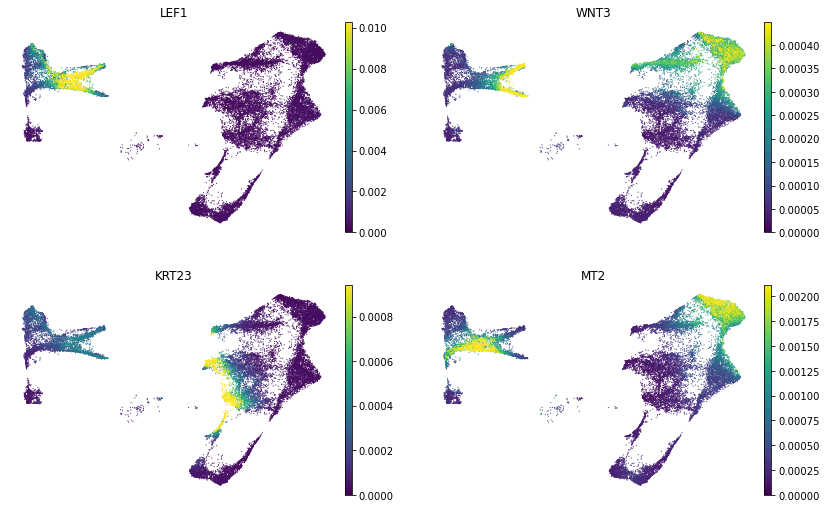

In [18]:
sc.pl.umap(rna_data, color = litemodel.genes, frameon=False, color_map='viridis',
          layer='LITE_prediction', ncols=2, vmin = 0, vmax = 'p97')

**Gene Expression:**

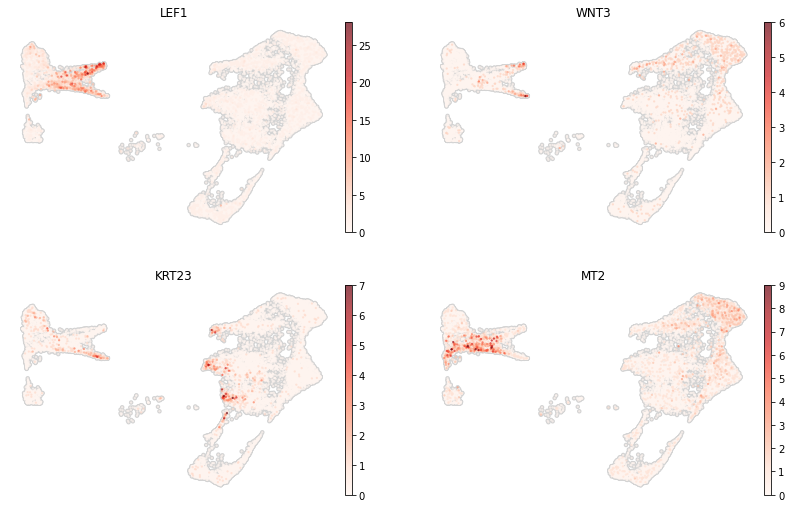

In [19]:
sc.pl.umap(rna_data, color = litemodel.genes, **mira.pref.raw_umap(ncols=2, size = 20))

## Gene-TF targeting 

### With probabilistic *in-silico* deletion (pISD)

RP models define a local chromatin neighborhood where changes in accessibility appear to influence gene expression. One may assume that transcription factor binding in many *cis*-regulatory elements within this neighborhood suggests the transcription factor regulates the gene of interest. MIRA can query for these types of interactions at a systems level, finding potential regulatory associations across many gene-TF pairs. 

The algorithm for calculating these associations is called probabilistic *in-silico* deletion (pISD), and it measures the ability of the RP model to predict expression of a gene before and after the regulatory elements predicted to bind a certain transcription factor are masked. In this way, pISD simulates a "computational knock out" of that factor.

To compute association scores using each RP model against motif-based binding site predictions of all available transcription factors, use `litemodel.probabilistic_isd`:

In [20]:
litemodel.probabilistic_isd(**rp_args, n_workers = 4)

Predicting TF influence:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.rp_model:Appending to expression adata:
INFO:mira.adata_interface.rp_model:Added key to varm: 'motifs-prob_deletion')
INFO:mira.adata_interface.rp_model:Added key to layers: motifs-informative_samples
INFO:mira.adata_interface.rp_model:Added key to uns: motifs


This test defines a matrix of association scores between gene-TF pairs. We can access this matrix directly with:

In [21]:
isd_matrix = mira.utils.fetch_ISD_matrix(rna_data) # ISD results stored in RNA AnnData

isd_matrix # genes are rows, TFs are columns

,SMAD4,SRF,HOXC13,CRX,GLI2,FOXK1,RUNX2,FOXP3,NR2F1,CREB3L2,...,HOXC12,HOXA9,HOXB4,NR1H2::RXRA,NR4A2,PLAGL2,HES7,NFATC4,ARF2,SMAD5
gene,,,,,,,,,,,,,,,,,,,,,
KRT23,-1.031236,0.442984,1.278907,1.275197,-3.894228,-4.737786,0.145845,-5.880801,-5.873926,-0.391286,...,3.776555,2.103447,15.006018,-0.675735,0.431147,0.000000,-0.073915,3.186979,-4.136086,1.548757
LEF1,1.555953,2.890195,1.972415,-2.492892,53.817509,2.190754,-4.308169,0.618104,0.053973,53.197016,...,3.347937,0.002139,58.846224,-0.053677,0.064043,-3.088581,54.655603,-44.617551,-0.242873,-0.012537
MT2,5.171670,-0.562885,-0.568174,-0.130994,-14.208664,-2.496724,5.804660,-0.133152,-1.373491,0.439853,...,-0.611781,-0.067728,3.564394,3.903828,-0.346076,0.533191,-1.488740,-2.535025,2.411952,0.640825
WNT3,-0.109940,2.937430,-0.602273,-2.626871,1.018678,-0.890162,-0.030161,-0.798166,4.341211,1.745296,...,0.000000,0.000000,-3.096827,0.675176,-2.373603,-0.593425,1.070695,-1.499021,-1.099836,0.045711


To find the top transcription factors associated with binding sites within **WNT3's** neighborhood:

In [22]:
isd_matrix.loc['WNT3'].sort_values().tail(10)

NR1H4         15.686037
KLF13         15.933641
KLF12         16.492668
RBPJ          17.132557
KLF16         18.546747
STAT3         18.610145
PRDM1         22.031852
ARID3A        23.249572
KLF11         24.054085
EWSR1-FLI1    26.278019
Name: WNT3, dtype: float64

Of these transcription factors, **RBPJ** is interesting because it is a key regulator of late hair follicle differentiation spurred by Notch signaling.

### Querying with many genes

One key limitation of the pISD algorithm is that binding site predictions are noisy - whether based on ChIP samples or especially as defined by motifs. Additionally, proximal binding predictions do not gaurantee mechanistic regulation. As such, testing one gene or one TF at a time is inadvisable. 

Querying for shared association with transcription factors across many co-regulated genes, however, produces results much more robust to the afforementioned sources of error. As part of the MIRA study, we computed association scores between 4000 genes and 555 TF motifs. Let's load those results and test them against an interseting geneset.

In [23]:
rna_data = anndata.read_h5ad('mira-datasets/shareseq_annotated_data/rna_data.joint_representation.rp_modeled.h5ad')

In [24]:
print('{} Genes, {} Factors'.format(
    *mira.utils.fetch_ISD_matrix(rna_data).shape
))

4883 Genes, 555 Factors


Now we can query with many genes at a time to find potential regulators. The following query finds TF regulators of genes activated by the hair follicle **Cortex** cells topic via *Wilcoxon* test over the association scores:

In [25]:
isd_results = mira.tl.driver_TF_test(rna_data, geneset=rna_model.get_top_genes(10, 150))

pd.DataFrame(isd_results).sort_values('pval').head(15)

INFO:mira.tools.tf_targeting:Testing with 144 query genes and 4739 background genes, against 555 factors


Testing factors:   0%|          | 0/555 [00:00<?, ?it/s]

,id,name,parsed_name,pval,test_statistic
247,MA0523.1,TCF7L2,TCF7L2,4.800274e-08,430104.5
205,MA0905.1,HOXC10,HOXC10,1.480306e-06,419074.0
164,MA0768.1,LEF1,LEF1,2.535205e-06,417234.0
315,MA0879.1,DLX1,DLX1,3.612823e-06,415980.0
496,MA0485.2,HOXC9,HOXC9,4.001443e-06,415557.0
411,MA0634.1,ALX3,ALX3,4.295351e-06,415366.0
385,MA0902.2,HOXB2,HOXB2,4.534243e-06,415160.5
540,MA0880.1,DLX3,DLX3,5.452141e-06,414503.0
457,MA0881.1,DLX4,DLX4,5.452141e-06,414503.0
195,MA1507.1,HOXD4,HOXD4,6.311274e-06,413973.0


Fantastic. The top results show WNT-related (TCF, LEF1), homeobox (DLX), and HOXC (HOXC13) motifs are enriched in the chromatin neighborhoods of genes upregulated in the cortex. 

As with topic enrichment, it is often instructive to compare and contrast regulators acting on two sets of genes. The [mira.pl.compare_driver_TFs_plot](plotting/mira.pl.compare_driver_TFs_plot.html#mira.pl.compare_driver_TFs_plot) function takes two genesets and calculates TF enrichment against both. In this case, I compare regulators of the top 150 genes associated with hair follicle **Cortex** and **Medulla** topics, respectively:

INFO:mira.tools.tf_targeting:Testing with 144 query genes and 4739 background genes, against 555 factors


Testing factors:   0%|          | 0/555 [00:00<?, ?it/s]

INFO:mira.tools.tf_targeting:Testing with 146 query genes and 4737 background genes, against 555 factors


Testing factors:   0%|          | 0/555 [00:00<?, ?it/s]

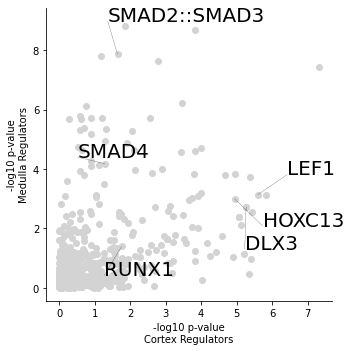

In [26]:
mira.pl.compare_driver_TFs_plot(rna_data, 
                                geneset1=rna_model.get_top_genes(10, 150), 
                                geneset2=rna_model.get_top_genes(5, 150),
                                label_factors=['SMAD2::SMAD3','SMAD4','LEF1','HOXC13','RUNX1','DLX3'],
                                fontsize=20, figsize=(5,5), color='lightgrey',
                                axlabels= ('-log10 p-value\nCortex Regulators','-log10 p-value\nMedulla Regulators'))
plt.show()

## Visualizing RP models

After identifying TF regulators of a gene-of-interest, you may want to visualize that gene's *cis*-regulatory neighborhood and assess binding sites. More comprehensive epigenetic visualization is coming in future updates of MIRA, but for now, we recommend using [pygenometracks](https://pygenometracks.readthedocs.io/en/latest/). Install pygenometracks using:

```
conda install -c conda-forge -c bioconda -y pygenometracks
```

You can use the RP model's [write_bedgraph](rpmodeling/mira.rp_model.rp_model.GeneModel.html#mira.rp_model.rp_model.GeneModel.write_bedgraph) method to write the RP model profile to a bedgraph file, which can be plotted by pygenometracks. 

In [27]:
!mkdir -p data/trackdata

In [28]:
litemodel['WNT3'].write_bedgraph(atac_data, 
                                 save_name = 'data/trackdata/WNT3_rpmodel.bedgraph')

Earlier, we found that WNT3 and RBPJ share a high association score. Let's see where RBPJ motifs are landing around the WNT3 locus. One can access the matrix of all TF motif binding predictions by `fetch_factor_hits`, or get a list of peaks predicted to be bound by RBPJ via `fetch_binding_sites`. Motifs are accessed by unique IDs, so first we need to find the ID for RBPJ:

In [29]:
factors = mira.utils.fetch_factor_meta(atac_data)
factors[factors.name == 'RBPJ']

,id,name,parsed_name
1035,MA1116.1,RBPJ,RBPJ


In [30]:
rbpj_binding = mira.utils.fetch_binding_sites(atac_data, id = 'MA1116.1')
rbpj_binding.head(3)

,chr,start,end,endogenous
peak_id,,,,
15,chr6,113306525,113306825,False
18,chr18,21300223,21300523,False
21,chr13,119690114,119690414,False


In [31]:
# sort by chromosome, then start site
rbpj_binding[['chr','start','end']].sort_values(['chr','start'])\
    .to_csv('data/trackdata/RBPJ_hits.bed',  # save as bed file
           index = None, header=None, sep = '\t',
           )

Now we define a configuration file for the pygenometracks plot we wish to make (see their extensive documentation on building plots). Of note, for the `[genes]` heading, we can provide the same TSS annotation as was used in training the RP models, since it is a valid bed12 file.

In [32]:
config_file = """

[x-axis]

[genes]
file = data/trackdata/tss_data.bed
title = Genes
height = 3

[rp model]
file = data/trackdata/WNT3_rpmodel.bedgraph
height = 3
color = #e6e6e6
title = WNT3 RP Model
max_value = 1.1
min_value = 0
file_type = bedgraph
alpha = 0.2

[rp model2]
file = data/trackdata/WNT3_rpmodel.bedgraph
type = line:0.5
color = black
file_type = bedgraph
max_value = 1.1
min_value = 0
overlay previous = yes

[spacer]

[RBPJ hits]
file = data/trackdata/RBPJ_hits.bed
height = 1.5
style = UCSC
gene_rows = 1
color = red
title = RBPJ Motif Hits
labels = off

"""

with open('data/trackdata/config.ini', 'w') as f:
    print(config_file, file = f)

Finally run the plotting command. To find a plotting location for a given gene, you can reference:

In [33]:
mira.utils.fetch_TSS_data(atac_data)['WNT3']

{'gene_chrom': 'chr11',
 'gene_start': 103774149,
 'gene_end': 103817957,
 'gene_strand': '+'}

In [34]:
!pygenometracks \
    --tracks data/trackdata/config.ini \
    --region chr11:103674149-103917957 \
    -out data/trackdata/wnt3_plot.png \
    --dpi 300 \
    --width 20 \
    --fontSize 9

/bin/bash: pygenometracks: command not found


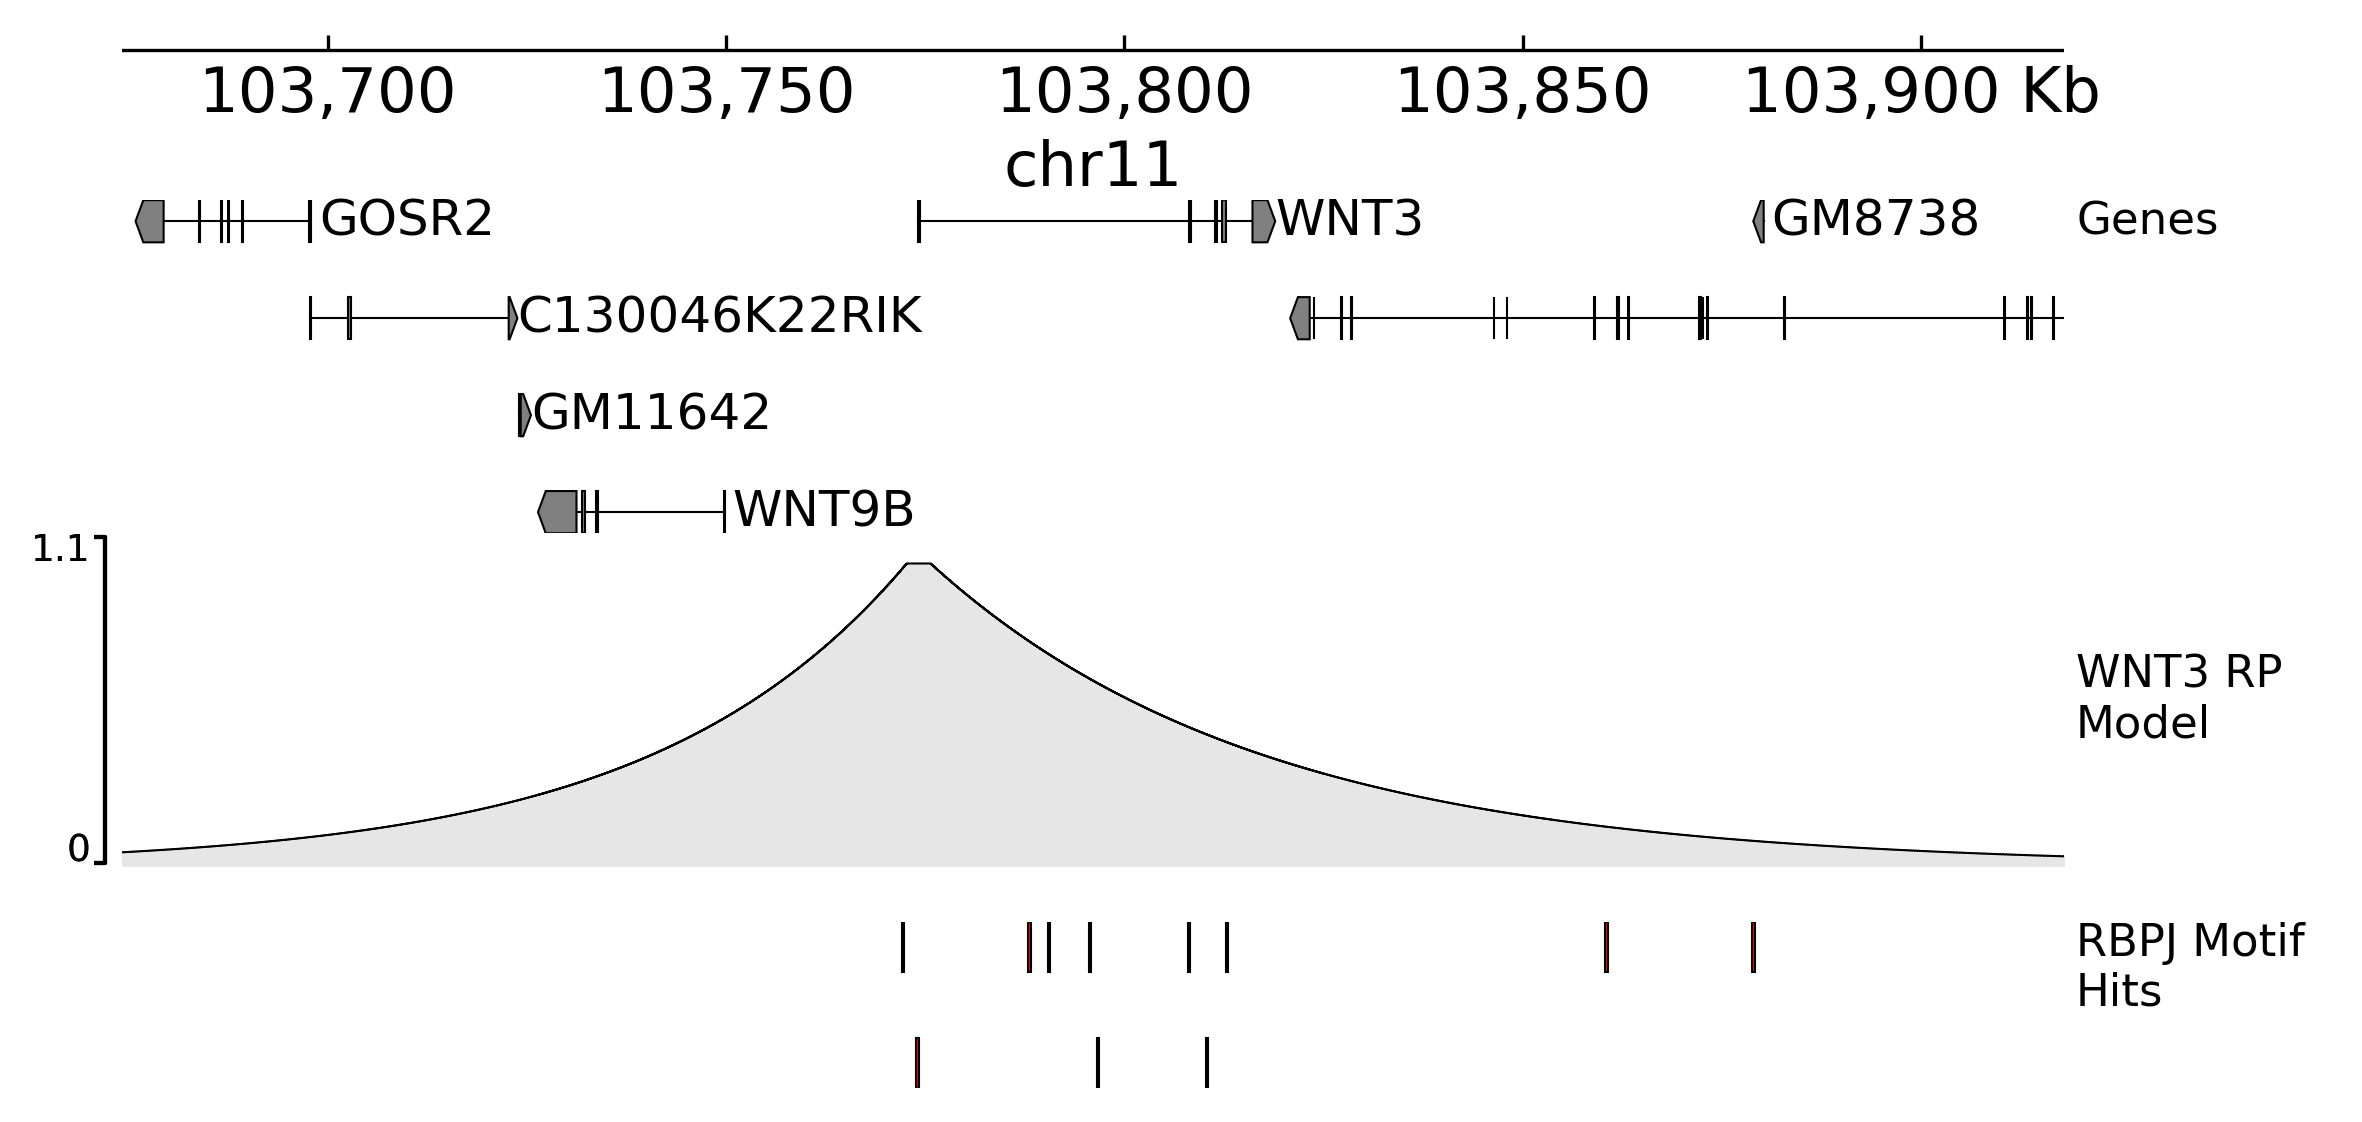

In [35]:
Image('data/trackdata/wnt3_plot.png')

**RBPJ** appears to bind many regions proximal to **WNT3's** local chromatin neighborhood, defined by the bounds of the learned regulatory potential function.

### Next

LITE models quantify a relationship between local chromatin accessibility and gene expression. Interestingly, for some genes, changes in local chromatin appear to diverge from changes in gene expression. The next tutorial on **NITE regulation** demonstrates how to identify and analyze this phenomenon.